<a href="https://colab.research.google.com/github/andrew-okello/wearable_classifciaction/blob/main/wearables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IndabaX Uganda 2021 - Deep Feed-forward Networks**
© Deep Learning Indaba. Apache License 2.0.

## **Introduction**
In this practical, we implement and train a feed-forward neural network (also known as an "MLP" for "multi-layer perceptron") of multiple layers on a dataset called "Fashion MNIST", consisting of small greyscale images of items of fashion. We consider the practical issues around generalisation to out-of-sample data and introduce some important techniques for addressing this.

**Learning Objectives:**
*   Understand how to use Tensorflow Eager and Keras Layers to build a large dataset pipeline a neural network architecture
*   Understand how a model is trained and evaluated
*   Be able to explain why there is a difference between in-sample and out-of-sample model performance
*   Understand the concept of train/validation/test split and why it's useful
Research techniques that can be used to improve model generalisation
*   Think about some of the modern challenges around understanding deep learning


In [2]:
#@title Imports (RUN ME!) { display-mode: "form" }

!pip install tensorflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

TensorFlow executing eagerly: True


## **The Data**

In this practical, we use the Fashion MNIST dataset consisting of 70,000 greyscale images and their labels. The dataset is divided
 into 60,000 training images and 10,000 test images. The idea is to train a **classifier** to identify the class value (what type of fashion item it is) given the image. We train and *tune* a model on the 60,000 training images and then evaluate how well it classifies the 10,000 test images that the model did not see during training. This task is an example of a **supervised learning** problem, where we are given both input and labels (targets) to learn from. This is in contrast to **unsupervised learning** where we only have inputs from which to learn patterns or **reinforcement learning** where an agent learns how to maximise a reward signal through interaction with its environment. 

In [3]:
# Tensorflow has convenient modules for loading a number of standard datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = fashion_mnist.load_data()

text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step


### Train/Validation/Test Split


When we build machine learning models, the goal is to build a model that will perform well on *future* data that we have not seen yet. We say that we want our models to be able to **generalise** well from whatever training data we can collect and do have available, to whatever data we will be applying them to in future. To do this, we split whatever data we have available into a **training set, a validation set and a test set**. The idea is that we train our model and use the performance on the validation set to make any adjustments to the model and its hyperparameters, but then we report the final accuracy on the test set. The test set (which we never train on), therefore acts as a proxy for our future data.

### Construct a validation set
Next, we remove 10,000 images and labels from the training set to use as a validation set. We will come back to the validation set later! 

In [4]:
# Construct a validation set from the last 10000 images and labels from
# train_and_validation_images and train_and_validation_labels
validation_images = train_and_validation_images[-10000:, :, :]
validation_labels = train_and_validation_labels[-10000:]

# Construct a training set from the first 50000 images and labels.
train_images = train_and_validation_images[:50000, :, :]
train_labels = train_and_validation_labels[:50000]

### What does the data look like?
Each image in the dataset consists of a 28 x 28 matrix of greyscale pixels. The values are between 0 and 255 where 0 represents black, 255 represents white and there are many shades of grey in-between. Each image is assigned a corresponding numerical label, so the image in ```train_images[i]``` has its corresponding label stored in ```train_labels[i]```. We also have a lookup array called ```text_labels``` to associate a text description with each of the numerical labels. For example, the label 1 is associated with the text description "Trouser".

The 2 cells below demonstrate how to visualise the input data. Make sure you understand what's happening, particularly how the indices correspond to individual items in the dataset. 

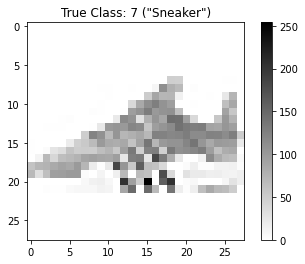

In [5]:
# We use the Matplotlib plotting library to visualise an image selected at random from the training set
plt.figure()
random_index = np.random.randint(0, len(train_images))
plt.imshow(train_images[random_index], cmap='gray_r')
plt.colorbar()
numerical_label = train_labels[random_index]
text_description = text_labels[numerical_label]
plt.title('True Class: {} ("{}")'.format(numerical_label, text_description))

plt.gca().grid(False)

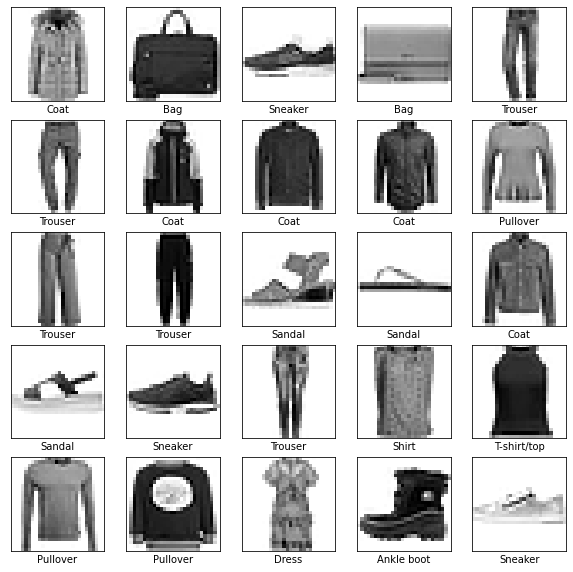

In [6]:
# Another view, showing 25 randomly selected images at a time
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap="gray_r")
    plt.xlabel(text_labels[train_labels[img_index]])

### Exploratory Task
Run the above cells multiple times to get a good sense of the dataset. Look at the general structure of the images and their corresponding labels. Can you spot some classes that might be difficult for a classifier to distinguish? If so, why do you think they would be difficult to distinguish?Feel free to discuss on the chat or share any thoughts you have with the group. 


### Preparing the data with TensorFlow
At the moment, our training data consists of two large tensors. The images are stored in a tensor of shape $[50000, 28, 28]$, consisting of all the $28 \times 28$ images matrices stacked together. The labels are stored in a 1D vector of shape $[50000]$. We wish to train a model using **mini-batch stochastic gradient descent**. In order to do so, we need to shuffle the data and split it into smaller (mini-)batches. We also convert the data from numpy arrays to TensorFlow Tensors.

In order to do this batching (and shuffling) we will use the Tensorflow [Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), which is a set of simple reusable components that allow you to build efficient data pipelines. Data is said to "stream" through the pipeline, meaning that when something at the output of the pipeline wants data, the pipeline will provide that data as soon as it has enough, rather than waiting to process all the data. This allows you to easily build pipelines that work on large datasets without having to load it all into memory in one go!

We build this pipeline step-by-step:

We start by defining the ```batch_size``` hyperparameter of our model. This hyperparameter controls the sizes of the mini-batches (chunks) of data that we use to train the model. The value you use will affect the memory usage, speed of convergence and potentially also the performance of the model. It also interacts with the *learning rate* used in gradient descent. 

In [7]:
batch_size = 128

The first component we add will group the image and label tensors together into a tuple and then split them into individual entries - ie. 50000 tuples containing a (28, 28) dimensional image and 1D label associated with that image. The following line adds this splitting component to the pipeline.

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

The next thing we do is apply a map operation. This lets us run an arbitrary function on each element. The function we provide returns the image values divided by 255 and converted ('cast') to a float and the label converted to a 32-bit integer.

**NOTE**: "Lambda" functions are just one-line, anonymous functions. In this case, it defines a function that takes arguments x and y (before the colon), and outputs their manipulated values (after the colon).

In [9]:
# Divide image values and cast to float so that they end up as a floating point number between 0 and 1
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

Then we add a **shuffle** component. This returns a random element from the pipeline.

In [10]:
# Shuffle the examples.
train_ds = train_ds.shuffle(buffer_size=batch_size * 10)

The final component in our pipeline is the batch component. This just requests `batch_size` elements from the previous pipeline component, groups them together into a single tensor and returns that.

In [11]:
# Now "chunk" the examples into batches
train_ds = train_ds.batch(batch_size)

# The output of this pipeline will be tuples of tensors containing images and labels.
# The images will be of shape (batch_size, 28, 28) and the labels of shape (batch_size, )

Finally, we apply the same pre-processing (converting to Tensors and normalising the values to lie between 0 and 1) to the validation set. 

In [12]:
# Don't worry about this for now, we will use the validation set later
val_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

## **The model**

In this section we'll build a classifier. A **classifier** is a function that takes an object's characteristics (or "features") as inputs and outputs a prediction of the class (or group) that the object belongs to. It may make a single prediction for each input or it may output some score (for example a probability) for each of the possible classes. Specifically, we will build a classifier that takes in (a batch of) 28 x 28 Fashion MNIST images as we've seen above, and outputs predictions about which class the image belongs to. 

For each (batch of) input images, we will use a **feed-forward neural network** to compute un-normalised scores (also known as **logits**) for each of the 10 possible classes that the image could belong to. We can then **classify** the image as belonging to the class which receives the highest score, or we can quantify the model's "confidence" about the classifications by converting the scores into a probability distribution. 

A feed-forward neural network consisting of $N$ layers, applied to an input vector $\mathbf{x}$ can be defined as:

\begin{equation}
\mathbf{f_0} = \mathbf{x} \\
\mathbf{f_i} = \sigma_i(\mathbf{W_if_{i-1}} + \mathbf{b_i}) \ \ \ i \in [1, N]
\end{equation}

Each layer has a particular number, $m_i$, of neurons. The parameters of a layer consist of a matrix $\mathbf{W_i} \in \mathbb{R}^{m_i \times m_{i-1}}$ and bias vector $\mathbf{b_i} \in \mathbb{R}^{m_i}$. Each layer also has a non-linear activation function $\sigma_i$. 

**QUESTION**: Why do you think the activation functions need to be *non-linear*? What would happen if they were *linear*? **HINT**: If you're stuck, consider the very simplest case of an identity activation (which essentially does nothing) and ignore the biases. 


### Activation functions



Activation functions are a core ingredient in deep neural networks. In fact they are what allows us to make use of multiple layers in a neural network. There are a number of different activation functions, each of which are more or less useful under different circumstances. The four activation functions that you are most likely to encounter are, arguably, [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU), [Tanh](https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh), [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid), and [Softmax](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Softmax). 

ReLU, has in recent years, become the default choice for use in MLPs and Convolutional Neural Networks (CNNs). ReLU has two advantages over Tanh and Sigmoid: it is computationally much more efficient, and, it allows us to use deeper networks because it does not suffer from [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). As a result of their success, a number of ReLU variants, such as [LeakyRelu](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) and [PReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/PReLU), have been developed.

Sigmoid and Softmax activations are often found after the last layer in binary and multi-class classification networks, respectively, as they transform the outputs of the network in such a way that we can interpret them as class probabilities.

Both Tanh and Sigmoid are found in LSTM and GRU recurrent neural networks, which we will find out more about in the coming days. They are also useful in MLPs and CNNs where we want the output to be bounded between -1 and 1 (Tanh) or 0 and 1 (Sigmoid).

Read more about activation functions [here](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6). 

### Configure the feed-forward neural network
We configure the feed-forward neural network part of our classifier using the [Keras Layers API](https://www.tensorflow.org/api_docs/python/tf/keras/layers). This API consists of various reusable building-blocks that allow us to define many different neural network architectures (similar to how we defined a data pipeline earlier!). 

Here we use the [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) component which allows us to wrap together a sequence of layers. An important point to note here is that we are **configuring** our neural network architecture as a pipeline. We can think of the resulting ```model`` variable as a *function* that takes a batch of images as inputs and outputs a batch of logits. 

In [13]:
# RE-RUN THIS CELL if you want to restart training!
# We will modify this definition later! 

model = tf.keras.Sequential([
    # Convert the 28x28 image into a flat vector of 28x28 = 784 values
    tf.keras.layers.Flatten(input_shape=(28, 28), name='flatten_input'),
    # Create a "hidden" layer with 256 neurons and apply the ReLU non-linearity
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name='input_to_hidden1'),
    # Create another hidden layer with 128 neurons
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1_to_hidden2'),
    # Create an "output layer" with 10 neurons
    tf.keras.layers.Dense(10, name='hidden_to_logits'),
])

The following summary shows how many parameters each layer is made up of (the number of entries in the weight matrics and bias vectors). Note that a value of ```None``` in a particular dimension of a shape means that the shape will dynamically adapt based on the shape of the inputs. In particular, the output shape of the ```flatten_input``` layer will be $[N, 784]$ when the batch of inputs passed to the model has shape $[N, 28, 28]$

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (Flatten)      (None, 784)               0         
_________________________________________________________________
input_to_hidden1 (Dense)     (None, 256)               200960    
_________________________________________________________________
hidden1_to_hidden2 (Dense)   (None, 128)               32896     
_________________________________________________________________
hidden_to_logits (Dense)     (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


**QUESTION**: Note that the flattening operation has no parameters. However, the Dense (fully-connected) layer mapping from the 784-D output of the flatten operation to the 256-D hidden layer has 200,960 parameters! Can you explain why the dense layer has 200,960 parameters? **HINT**: Refer back to the equations of a feed-forward network.

### Define the loss
As we did in the previous practical, we need to specify a loss function for our classifier. This tells us how good our model's predictions are compared to the actual labels (the targets), with a lower loss meaning better predictions. The standard loss function to use with a **multi-class classifier** is the **cross-entropy loss** also known as the "negative log likelihood" for a classifier. Suppose we have a classification problem with $C$ classes. A classifier is trained to predict a probability distribution $p(y | X_i)$ for each input $X_i$ from a batch of $N$ examples. The vector $p(y|X_i)$ is $C$ dimensional, sums to one, and we use $p(y|X_i)_c$ to denote the $c$th component of  $p(y|X_i)$. The true class for example $i$ in the batch is $y_i$ and we define the indicator function $\mathbb{1}[y_i=c]$ to be 1 whenever $y_i = c$ and $0$ otherwise. This classifier has a cross-entropy loss of

$- \frac{1}{N}\sum_{i=1}^N \sum_{c=1}^C log( p(y|X_i)_c) \mathbb{1}[y_i=c]$

**NOTE**: The indicator is one for the true class label, and zero everywhere else. So in that sum, the indicator just "lifts out" the $log(p(y|X_i))$ values for all true classes. So the above expression is minimised (note the negative at the front) when the model places all its probability mass on the true labels for all the examples. Remember that  log(1)=0 , thus the closer all probabilities of $y_i = c$ are to one, the lower the loss will be and the better the model will be performing.

**QUESTION**: 
* Why do you think this is a *good* loss function?
* Can you think of any potential issues with this loss function?

Fortunately we don't need to write this function ourselves as Tensorflow provides a version called 

```tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)```. 

**NOTE**: This function actually computes the cross entropy loss directly from the un-normalised logits, rather than from the probability distribution for numerical stability. It also uses the integer labels rather than the one-hot encoding. If labels are provided in one-hot format, please use CategoricalCrossentropy loss.

By the way, for training data in which the labels are themselves distributions rather than exact values, this definition of cross-entropy still works, where the indicator function is replaced with the corresponding probability of each class for that example. This might be important when we are not sure whether the training data has been labelled correctly, or when the data was labelled by a human who gave their answer along with a degree of confidence that the answer was correct

## Train the model
Now that we have our data, data processing pipeline, our neural network architecture and the corresponding loss that we want to minimise, we need to **train** the model using batched stochastic gradient descent. We do this in multiple **epochs**, which is a single iteration through the entire training dataset. Briefly, in each epoch we loop over all the batches of images and labels, and for each batch we perform the following steps:
* Get the **predictions** of the model on the current batch of images
* Compute the **average loss** values across the batch, telling us how good these predictions are / how close they are to the true targets.
* Compute the **gradient of the average loss** (or the average gradient of the losses in the batch) with respect to each of the model's parameters: This tells us the direction to move in "parameter space" to decrease the loss value
* **Adjust the parameters** by taking a small step in the direction of each component of the gradient (where the learning rate controls the size of the step)

During training we also track some metrics, such as the loss and accuracy to see how well the classifier is doing. Note that the cell below may take a few minutes to run! 



### Computing gradients in Eager mode



In graph mode, TensorFlow builds up a "computation graph" which captures all operations of the model and their dependencies. For training, the gradient can then be computed by traversing backwards from every node through its dependents and applying the "chain rule" of differentiation. 

However, in Eager mode, we don't have the concept of the computation graph anymore. Operations are performed imperatively (in the order in which they were executed). TensorFlow therefore uses a mechanism called the "GradientTape" for computing gradients in Eager mode. Basically, the gradient tape records the order of all operations as they are executed, and can then be "run backwards" (traversed from last to first operation) for computing the gradients.

### Defining the training loop

In [15]:
# Choose an optimizer and loss function for training:
# The optimizer is responsible for controlling the learning rate
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

num_epochs = 50  # The number of epochs to run

# Lists to store the loss and accuracy of every epoch
train_losses = []
train_accuracies = []

# Defined a function to train the model using tf.GradientTape
@tf.function
def train_step(image, label):
  # Initialise a GradientTape to track the operations
  with tf.GradientTape() as tape:
    # Compute the logits (un-normalised scores) of the current batch of examples
    # using the neural network architecture we defined earlier
    logits = model(image)
    loss = loss_object(label, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  # Add current batch loss to our loss metric tracker - note the function call semantics
  train_loss(loss)
  train_accuracy(label, logits)

# Define a function to test the model
# @tf.function
# def val_step(image, label):
  # TODO

for epoch in range(num_epochs):
  # Loop over our data pipeline
  for image, label in train_ds:
    train_step(image, label)
      
  template = 'Epoch {:03d}, Loss: {:.3f}, Accuracy: {:.3%}'
  print(template.format(epoch+1,
                        train_loss.result(), 
                        train_accuracy.result()))
  
  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())

Epoch 001, Loss: 0.533, Accuracy: 81.158%
Epoch 002, Loss: 0.456, Accuracy: 83.706%
Epoch 003, Loss: 0.415, Accuracy: 85.091%
Epoch 004, Loss: 0.389, Accuracy: 85.971%
Epoch 005, Loss: 0.369, Accuracy: 86.664%
Epoch 006, Loss: 0.353, Accuracy: 87.203%
Epoch 007, Loss: 0.340, Accuracy: 87.650%
Epoch 008, Loss: 0.328, Accuracy: 88.017%
Epoch 009, Loss: 0.318, Accuracy: 88.378%
Epoch 010, Loss: 0.309, Accuracy: 88.673%
Epoch 011, Loss: 0.301, Accuracy: 88.958%
Epoch 012, Loss: 0.293, Accuracy: 89.224%
Epoch 013, Loss: 0.287, Accuracy: 89.453%
Epoch 014, Loss: 0.280, Accuracy: 89.685%
Epoch 015, Loss: 0.274, Accuracy: 89.899%
Epoch 016, Loss: 0.268, Accuracy: 90.111%
Epoch 017, Loss: 0.262, Accuracy: 90.306%
Epoch 018, Loss: 0.257, Accuracy: 90.491%
Epoch 019, Loss: 0.252, Accuracy: 90.676%
Epoch 020, Loss: 0.247, Accuracy: 90.849%
Epoch 021, Loss: 0.242, Accuracy: 91.013%
Epoch 022, Loss: 0.238, Accuracy: 91.170%
Epoch 023, Loss: 0.234, Accuracy: 91.315%
Epoch 024, Loss: 0.229, Accuracy: 

Text(0.5, 1.0, 'Accuracy vs epochs')

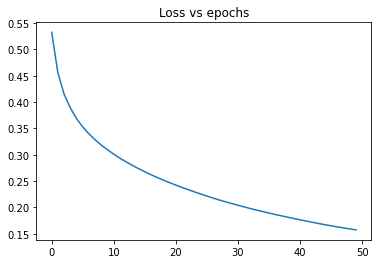

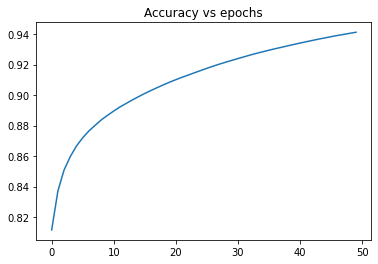

In [16]:
# Plot the loss for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), train_losses)
plt.title('Loss vs epochs')

# Plot the accuracy for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), train_accuracies)
plt.title('Accuracy vs epochs')

The above code block shows a typical training loop. 
Lets visualise some of the model's prediction on the training set

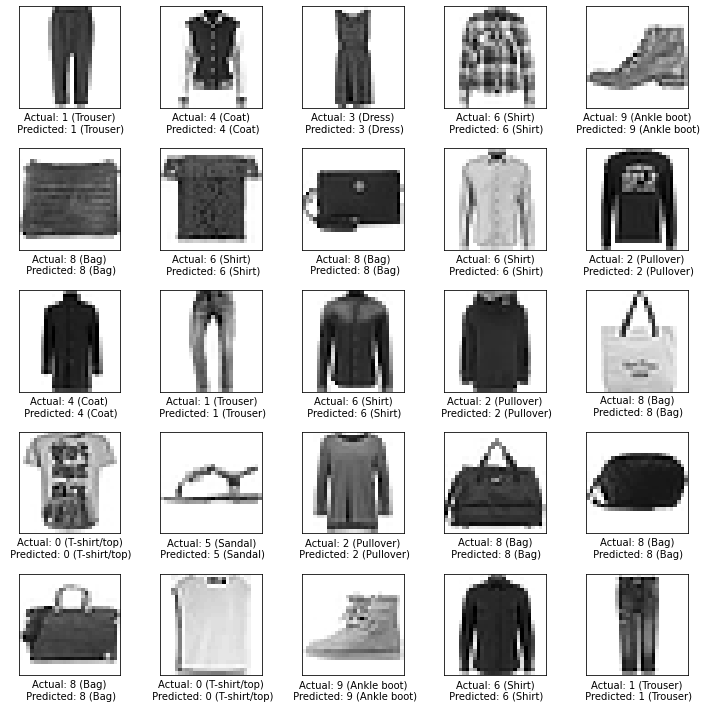

In [17]:
images, labels = next(iter(train_ds))  # Get a batch of images and labels

_logits = model(images, training=False)  # Pass the images to the model function and get its output logits
predicted_labels = tf.argmax(_logits, axis=1, output_type=tf.int32)

img_indexs = np.arange(images.numpy().shape[0])
np.random.shuffle(img_indexs)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = img_indexs[i]
    predicted_label = int(predicted_labels[img_index])

    plt.imshow(images[img_index], cmap="gray_r")

    actual_label = int(labels[img_index].numpy())
    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))

plt.tight_layout()
plt.show()

## Testing

After 50 epochs of training on our training set, we obtain a loss of around 0.1 and over 90% accuracy. That's pretty good, right? 

It is important to distinguish between data that is **in-sample** and **out-of-sample**. Our training data is all in-sample and we would expect any resonably powerful model (like an MLP) to be very accurate and have a low loss on this (in fact, with a sufficiently large MLP and enough training epochs, we can get the loss arbitrarily close to zero!). This *can be* considered as an undesirable outcome however, because pushing the loss close to zero may mean that the model has fit the **noise** in the training data rather than the true signal. If this is the case, it will not perform well on out-of-sample data that it has not seen before (which is what we really care about!). To assess this, we evaluate our trained model on the held-out test set (but we don't update the parameters of the model when testing it, that would be cheating!)

In [18]:
# We need to apply the same pre-processing to the test set as we did to the training set
# Since we don't need batching or shuffling, we can do this directly instead of
# building a tf.Dataset pipeline

tf_test_images = tf.convert_to_tensor(test_images, dtype=tf.float32) / 255.0
tf_test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

In [19]:
test_logits = model(tf_test_images, training=False)

# Compute the average cross-entropy loss of the classification over the entire test set
test_loss = tf.keras.metrics.Mean(name='test_loss')
t_loss = loss_object(tf_test_labels, test_logits)
test_loss(t_loss)

# Compare predicted labels to actual labels
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_accuracy(tf_test_labels, test_logits)

print('Completed testing on', tf_test_images.shape[0], 'examples...')
print('Loss: {:.3f}, Accuracy: {:.3%}'.format(test_loss.result(), test_accuracy.result()))

Completed testing on 10000 examples...
Loss: 0.613, Accuracy: 88.670%


And again we visualise some of the model's predictions:

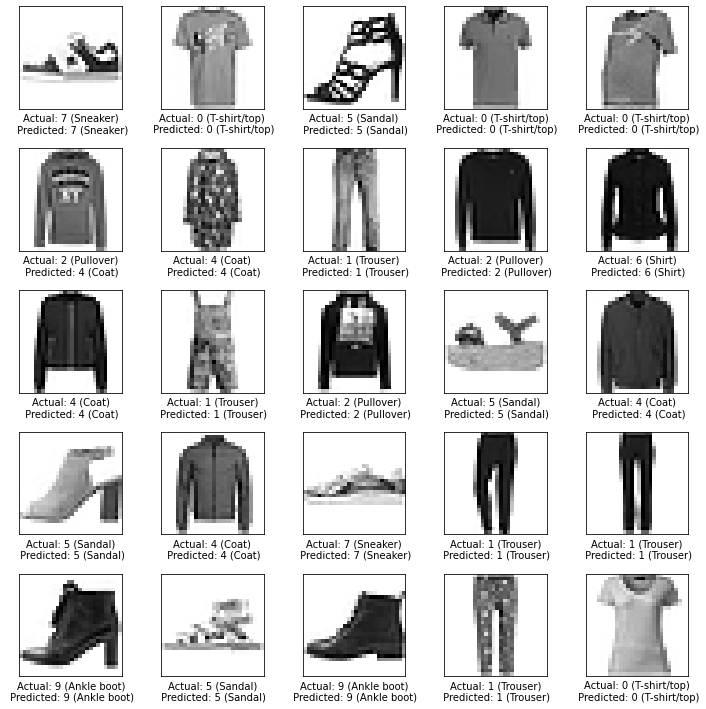

In [20]:
test_predictions = tf.argmax(test_logits, axis=1, output_type=tf.int32)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 10000)
    plt.imshow(test_images[img_index], cmap="gray_r")

    actual_label = int(test_labels[img_index])
    predicted_label = int(test_predictions[img_index])

    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))

plt.tight_layout()
plt.show()

What happened? We got over 90% accuracy on the training set, but only around 88% on the test set. This is an example of how a model's in-sample performance differs from its out-of-sample performance. It may even be considered **overfitting** (where the model failing to generalise its in-sample performance to unseen out-of-sample data). There are a number of ways we can address this, but first, it's important to realise that we should try and keep the number of evaluations on the test set to a minimum. 

**QUESTION**: Can you think of WHY we should limit the number of evaluations on the test set? This is an important point, so spend a few minutes thinking about it, discuss it on the chat or share your thoughts with the group! 

The first important method is called **validation**. Using validation, we reserve a portion of our training dataset and call it the validation set. After each epoch of training (or every K epochs where K can be a fraction), we evaluate our model on this validation set (without updating the model parameters). This gives us a good sense of how well we expect our model to do on out-of-sample data. In this way, the validation set acts as a surrogate for the test set which we can safely use during model development and training. We can also use this validation set to tune our model by selecting hyperparameters such as the batch size, sizes of layers or the network architecture. 


##**TASKS**:

1. Implement **Validation** by adding some code to the loop in the "Train the model" section (**TIP**: The code for evaluating on the validation set will be very similar to evaluating on the test set!): 
 * Evaluate your model on the validation set at the end of each training epoch and print the loss and accuracy on the validation set. We have already defined a validation set and done the necessary preprocessing for you. What do you notice?
 * Plot the validation loss and accuracy on the same axes as the training loss and accuracy, respectively.
  * Evaluate how closely the loss and accuracy on the validation set matches the eventual performance on the test set. 

2. Add $L_2$ and $L_1$ regularization to the model (see [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)). Can you think of what would be the differnece between these two regularizers? Monitor the effect on the validation/test sets. 

3. Add DROPOUT (see [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) and [research paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) ) to improve the model's generalisation.

4. Add BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [research paper](http://proceedings.mlr.press/v37/ioffe15.pdf)) to improve the model's generalisation.

5. Another way to improve the model generalizatoin is by artificially increasing the size of the training data, or what we call **data augmentation** ([TensorFlow documentation](https://www.tensorflow.org/tutorials/images/data_augmentation)). After examining the data, what operation(s) we can apply to the images to augment our data? Implement this and monitor the effect on the validation and the test sets. What if our datasets was composed of **natural images**? Can you think of other operations we can apply?

6.  Remove the shuffling from the dataset pipeline and compare the generalisation performance of the model with and without shuffling. 

7. [OPTIONAL] Change the optimizers and observe the effect on your model behavior. 

8. [OPTIONAL] Use a random subset of 1000 examples as your training set. Redefine your model to have one single hidden layer. Change the optimizer to SGD. Progressively increase the size of your hidden layer and monitor the performance on the validation set. What do you observe?  

9.  [OPTIONAL] Adjust the model architecture by adding layers and modifying other parameters to improve the performance on your **validation** set. Once you've settled on an architecture and hyperparameters, evaluate your model on the **test** set. See the Tensorflow documentation for examples of parameters you can change in the model.


## Important Tip
If you want to re-train your model, you need to rerun all the code in the "Define the model" section first. This is to ensure that the Tensorflow variables containing the model parameters get reset. If you don't do this, you're effectively running more epochs on an already-trained model.

## **On stochastic gradient descent**

#### Questions
* Can you explain what the difference is between normal stochastic gradient descent and "batched" stochastic gradient descent? What is the purpose of chunking data into batches during training? Are there any trade-offs? What are they? **HINT**: You can read [this blog post](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) for more details. Feel free to use the chat or share your thoughts with the group.
* Why is it important to randomise the data before chunking it into batches? 
* Think about the relation between the batch size and the learning rate.
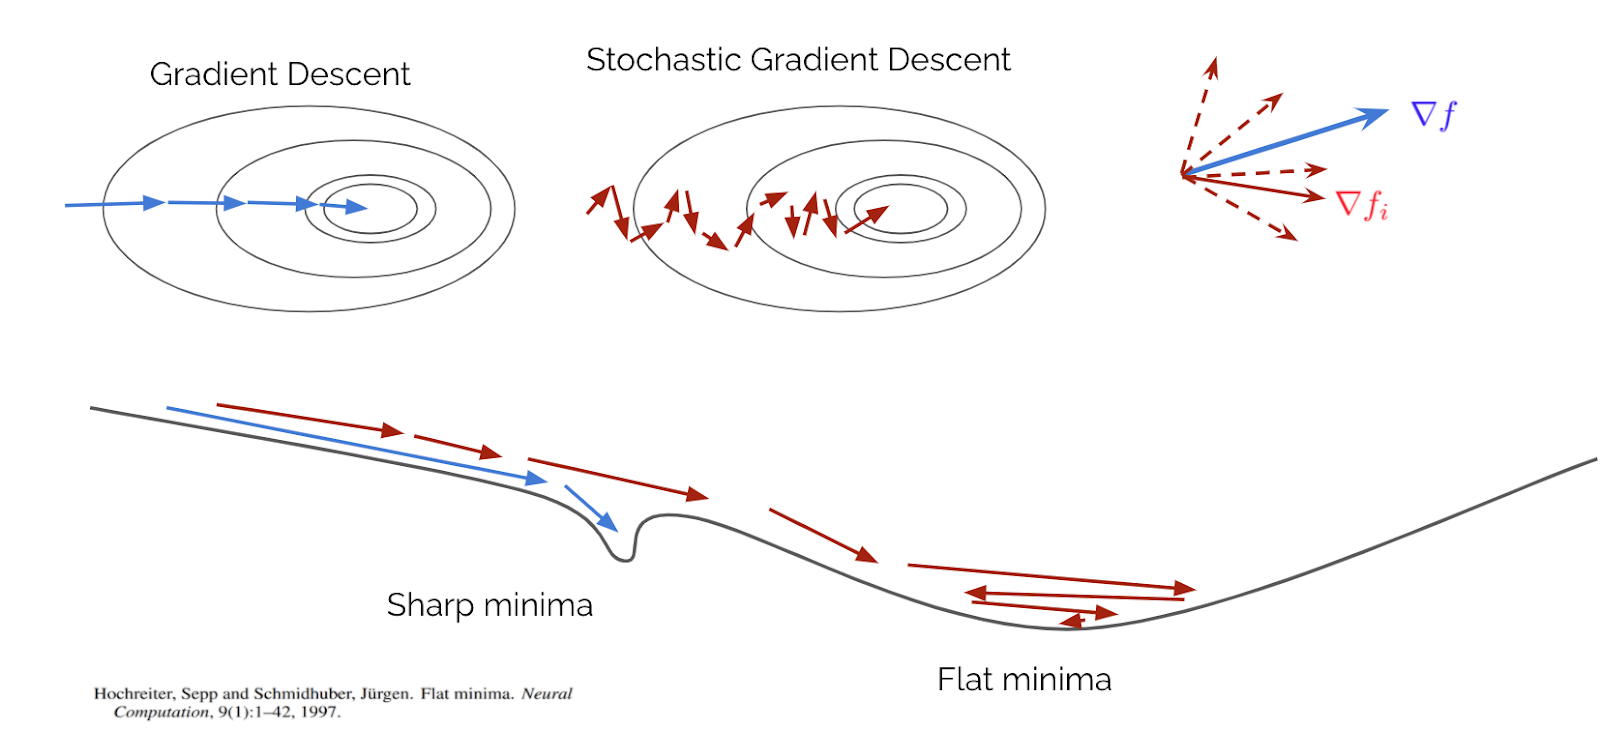

 ### Optimisation schemes

You might have noticed that we are using the Adam optimizer to train our neural networks. Adam is a variant of stochastic gradient descent which often performs well in practice. In fact, there is a whole range of variations on stochastic gradient descent that are often used. Here is an illustration showing how a few of these methods perform on a toy problem: 

![optimization methods](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

For a detailed description of various optimization methods read [this](http://ruder.io/optimizing-gradient-descent/) article. For a great visual discussion on how these methods work see [this](https://distill.pub/2017/momentum/) article.

## **Overfitting, underfitting and beyond**

### Overfitting and underfitting

In addition to the problem of _overfitting_ (in which the model is too complex and as a result is able to memorize the training data rather than learning a general pattern) there is the problem of _underfitting_ which is the opposite. Underfitting occurs when the model does not have enough complexity (also known as capacity) to learn a general pattern. While overfitting is characterised by diverging test/validation and training scores, underfitting is characterised by test/validation and training scores that very slowly continue to improve. 


Unlike overfitting which has a number of solutions, such as collecting more data, data augmentation, dropout, and L1/L2 regularization, underfitting has one simple solution: just make your model incrementally more complex until it no longer underfits.

![underandoverfitting](https://i.imgur.com/m2bSP1S.png)

## Modern view of Deep Learning - Double descent curve

This U-shaped curve is known since the Vapnik–Chervonenkis theory (developed between 1960-90). It translates the theorem stating that the gap between what the **true risk** (expected value of the loss on the whole population - usually inaccessible) and the **empirical loss** (mean of the loss on the accessible training data) is controlled by a quantity depending on the model complexity. 

**QUESTION** What would be a good measure of the model complexity for a neural network? 

In the recent years, more and more researchers shed a light on the fact that neural networks and more particularly the modern deep architectures, escape the predictions of this theory (for example, read [link paper](https://arxiv.org/pdf/1611.03530.pdf). This led to more investigation on the training/test loss behavior, which drew a new picture for deep neural networks: 


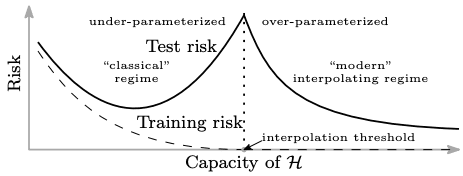

For more on this subject, read [link paper](/https://arxiv.org/pdf/1812.11118.pdf) and [link blog post](https://openai.com/blog/deep-double-descent/).
Try to reproduce this curve by following the instructions of 8. 

# Thank you for your attention! 